# 1. Understand the environment

Observation space: State consists of hull angle speed, angular velocity, horizontal speed,vertical speed, position of joints and joints angular speed, legs contact with ground, and 10 lidar rangefinder measurements. There are no coordinates in the state vector.

Action space: 4 motor speed values in the [-1, 1] range for each joints at each hip and each knee. Clipped if out of range.

Rewards: Reward is given for moving forward, totaling 300+ points up to the far end. If the robot falls, it gets -100. Applying motor torque costs a small amount of points.
    
Starting State: The walker starts standing at the left end of the terrain with the hull horizontal, and both legs in the same position with a slight knee angle.

Episode Termination: The episode will terminate if the hull gets in contact with the ground or if the walker exceeds the right end of the terrain length. If stuck in position e.g. repeatedly env.step([-1,-1,1,1]), then appears to terminate after 1600 timesteps.

Solved: To solve the normal version, you need to get 300 points in 1600 time steps. To solve the hardcore version, you need 300 points in 2000 time steps.

To use to the _hardcore_ environment, you need to specify env = gym.make("BipedalWalker-v3", hardcore=True)

# 2. Imports and prequesites

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.distributions import Categorical

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 3. Test the environment

In [2]:
env = gym.make('BipedalWalker-v3')
print('Start state:', env.reset())
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)
print('Example action:', env.action_space.sample())
print('Example item in action:', env.action_space.sample()[0])
print('Step:', env.step([0, 0, 0, 0]))

state = env.reset()
terminal = False
step = 1

while not terminal:
    env.render()
    next_state, reward, done, _ = env.step([-1,-1,1,1])
    if done == True:
        print(step)
        terminal = True
    else: 
        step = step + 1
        state = next_state    
env.close()

Start state: [ 2.7474663e-03 -1.0364647e-05  8.0627971e-04 -1.5999928e-02
  9.2008047e-02 -1.0640161e-03  8.6024189e-01  2.1893324e-03
  1.0000000e+00  3.2413889e-02 -1.0639436e-03  8.5379052e-01
  7.5248181e-04  1.0000000e+00  4.4081402e-01  4.4582012e-01
  4.6142277e-01  4.8955020e-01  5.3410280e-01  6.0246104e-01
  7.0914888e-01  8.8593185e-01  1.0000000e+00  1.0000000e+00]
Observation space: Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf], (24,), float32)
Action space: Box([-1. -1. -1. -1.], [1. 1. 1. 1.], (4,), float32)
Example action: [-0.76136565  0.8898186   0.9512343  -0.5428146 ]
Example item in action: -0.84728205
Step: (array([-5.2311434e-03, -3.9454090e-07, -2.8210764e-03, -1.2376304e-03,
        4.3553507e-01,  6.4770095e-02,  1.1488807e-01, -8.2322896e-02,
        1.0000000e+00,  3.3830014e-01, 

2022-04-22 01:24:03.921 python[48942:5447609] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f99d0549400>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-22 01:24:03.922 python[48942:5447609] Warning: Expected min height of view: (<NSButton: 0x7f99d0420890>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-22 01:24:03.924 python[48942:5447609] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f99d041f870>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-22 01:24:03.925 python[48942:5447609] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f99d042da50>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


1600


# 4. Define the neural network

In [3]:
class Network(nn.Module):
    def __init__(self, s_size, h_size, a_size):
        super(Network, self).__init__() 
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, h_size)
        self.fc3 = nn.Linear(h_size, a_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        params = (self.fc3(x))
        return params

# 5. Instantiate the neural network¶

In [4]:
policy = Network(s_size = 24, h_size = 64, a_size = 8).to(device)
optimizer = optim.Adam(policy.parameters(), lr=0.0001)

# 6. Define the algorithm to be used

In [5]:
def reinforce(n_episodes=100, gamma=1.0, print_every=10):

    scores = [] 
    scores_deque = deque(maxlen=print_every)    

    for i_episode in range(1, n_episodes+1):
        
        state = env.reset()
        terminal = False
        discounted_rewards = []
        saved_log_probs = [] 
        step = 1
        
        while not terminal:
            state = torch.from_numpy(state).float()
            params = policy(state) 
            action = []
            
            mu1 = F.tanh(params[0])
            sigma1 = nn.Sigmoid()(F.softplus(params[1]))
            distribution1 = Normal(mu1, sigma1)
            action1 = distribution1.sample()
            log_prob1 = distribution1.log_prob(action1)
            action.append(action1.item())
            
            mu2 = F.tanh(params[2])
            sigma2 = nn.Sigmoid()(F.softplus(params[3]))
            distribution2 = Normal(mu1, sigma1)
            action2 = distribution2.sample()
            log_prob2 = distribution2.log_prob(action2)
            action.append(action2.item())
            
            mu3 = F.tanh(params[4])
            sigma3 = nn.Sigmoid()(F.softplus(params[5]))
            distribution3 = Normal(mu3, sigma3)
            action3 = distribution3.sample()
            log_prob3 = distribution3.log_prob(action3)
            action.append(action3.item())
            
            mu4 = F.tanh(params[6])
            sigma4 = nn.Sigmoid()(F.softplus(params[7]))
            distribution4 = Normal(mu1, sigma1)
            action4 = distribution4.sample()
            log_prob4 = distribution4.log_prob(action4)
            action.append(action4.item())
            
            log_prob = log_prob1 + log_prob2 + log_prob3 + log_prob4
            saved_log_probs.append(log_prob)
            
            next_state, reward, done, _ = env.step(action)
            discounted_reward = reward*(gamma**step)
            discounted_rewards.append(discounted_reward)
            
            if done == True:
                terminal = True
            else: 
                step = step + 1
                state = next_state    
        
        G = sum(discounted_rewards)
        scores_deque.append(G)
        scores.append(G)
        rewards_togo = []
        
        for t in range(1, step-1): 
            rewards_togo.append(sum(discounted_rewards))
            discounted_rewards.pop(0)
        
        policy_loss = []
        
        for t in range(1, step-1): 
            policy_loss.append(-saved_log_probs[t-1] * rewards_togo[t-1])
        
        policy_loss = torch.stack(policy_loss).sum() 
        optimizer.zero_grad() 
        policy_loss.backward() 
        optimizer.step()
        
        if i_episode % print_every == 0: 
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

        if scores[i_episode-1] >=300.0 and step <= 1600:
            print('Environment solved in {:d} episodes!'.format(i_episode,))
            return scores
            
    return scores

# 7. Train the agent

In [6]:
scores = reinforce()

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 10	Average Score: -113.32
Episode 20	Average Score: -110.63
Episode 30	Average Score: -126.08
Episode 40	Average Score: -99.59
Episode 50	Average Score: -102.54
Episode 60	Average Score: -102.96
Episode 70	Average Score: -119.27
Episode 80	Average Score: -105.09
Episode 90	Average Score: -112.17
Episode 100	Average Score: -102.12


# 8. Plot rewards over episodes

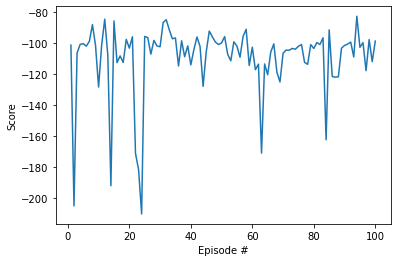

In [7]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# 9. Test the trained agent

In [8]:
for i in range(10):
    state = env.reset()
    terminal = False
    step = 1
    ep_reward = 0

    while not terminal:
        env.render()
        state = torch.from_numpy(state).float()
        params = policy(state)
        
        action = []
            
        mu1 = F.tanh(params[0])
        sigma1 = nn.Sigmoid()(F.softplus(params[1]))
        distribution1 = Normal(mu1, sigma1)
        action1 = distribution1.sample()
        action.append(action1.item())

        mu2 = F.tanh(params[2])
        sigma2 = nn.Sigmoid()(F.softplus(params[3]))
        distribution2 = Normal(mu1, sigma1)
        action2 = distribution2.sample()
        action.append(action2.item())

        mu3 = F.tanh(params[4])
        sigma3 = nn.Sigmoid()(F.softplus(params[5]))
        distribution3 = Normal(mu3, sigma3)
        action3 = distribution3.sample()
        action.append(action3.item())

        mu4 = F.tanh(params[6])
        sigma4 = nn.Sigmoid()(F.softplus(params[7]))
        distribution4 = Normal(mu1, sigma1)
        action4 = distribution4.sample()
        action.append(action4.item())
            
        next_state, reward, done, _ = env.step(action)
        ep_reward = ep_reward + reward 
        print(step)
        print(action)
        if done == True: 
            terminal = True
        else: 
            step = step + 1
            state = next_state
    
    print('Episode reward:', ep_reward)
    
env.close()

2022-04-22 01:26:04.328 python[48942:5447609] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f99d05906f0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-22 01:26:04.328 python[48942:5447609] Warning: Expected min height of view: (<NSButton: 0x7f99d0441ea0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-22 01:26:04.330 python[48942:5447609] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f99cf7df830>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-22 01:26:04.332 python[48942:5447609] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f99ce983960>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
/opt/anaconda3/lib/python3.

1
[0.03922908008098602, -0.565217137336731, -0.6210290193557739, -0.15167880058288574]
2
[-0.9393069744110107, 0.34899255633354187, -0.14319153130054474, 0.5200825929641724]
3
[-0.24768973886966705, 0.10211789608001709, -0.314216285943985, -1.0776997804641724]
4
[0.4187210202217102, -0.008576132357120514, 0.7256715893745422, 0.8158162832260132]
5
[-0.24847647547721863, -0.37294653058052063, -0.655346155166626, 0.8293825387954712]
6
[0.7123539447784424, -0.5557107329368591, 1.1377966403961182, -1.690181851387024]
7
[0.177428737282753, 0.28267765045166016, 0.9905022382736206, 0.07691739499568939]
8
[-0.10988135635852814, 0.5476899743080139, 0.44635576009750366, -0.6849178671836853]
9
[0.4649880528450012, -0.23802223801612854, 1.0884263515472412, -0.6827912330627441]
10
[0.7577191591262817, -0.08758312463760376, -0.5149250030517578, 0.32807037234306335]
11
[-0.03981800749897957, 0.23676741123199463, 0.48783886432647705, 1.001391053199768]
12
[-0.5378842353820801, -0.9437869787216187, 0.25

# 10. Compare to random agent

In [9]:
for i in range(5):
    state = env.reset()
    terminal = False
    step = 1
    ep_reward = 0

    while not terminal:
        env.render()
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        print(step)
        print(action)
        print(reward)
        ep_reward = ep_reward + reward 

        if done == True: 
            terminal = True
        else: 
            step = step + 1
            state = next_state
            
    print('Episode reward:', ep_reward)
    
env.close()

2022-04-22 01:27:25.221 python[48942:5447609] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f99cf5f57a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-22 01:27:25.221 python[48942:5447609] Warning: Expected min height of view: (<NSButton: 0x7f99d046ed30>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-22 01:27:25.223 python[48942:5447609] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f99d046f4c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-04-22 01:27:25.225 python[48942:5447609] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f99c87062b0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


1
[ 0.04092764 -0.646374    0.4603377   0.753217  ]
-0.046152130166687184
2
[ 0.03640373 -0.28040352 -0.6800893  -0.19281712]
-0.09629484272748233
3
[ 0.47055095  0.13750733 -0.805963    0.45755517]
-0.05849888453136006
4
[-0.69110674 -0.23768038  0.48733002 -0.6375594 ]
-0.1340224583322815
5
[-0.3274177  -0.59308165 -0.78257805 -0.23848888]
-0.20901611011226853
6
[-0.8350373   0.3881149   0.11507157  0.93384737]
-0.21174034699797628
7
[ 0.54930174 -0.01816458  0.17470695  0.6916802 ]
-0.12459950530529022
8
[-0.60455596 -0.43631282  0.9670779  -0.39164728]
-0.12534137658278266
9
[0.31253958 0.38258258 0.7831632  0.52754813]
-0.029979786793388537
10
[-0.31103435 -0.68325627  0.49654305  0.13811317]
-0.010340746978919894
11
[-0.80425316  0.7249899  -0.16381896  0.47991076]
-0.07662716337044916
12
[ 0.19615166 -0.28851312 -0.71503425 -0.8481778 ]
-0.11350754751761992
13
[-0.92644984  0.62350446  0.37422907  0.96606606]
-0.11923484953244409
14
[-0.62701106  0.8106767  -0.9695251   0.419392